# Imports Needed

In [1]:
#Imports needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from sklearn.base import BaseEstimator, ClassifierMixin  # Add this line

# Get Data


In [ ]:
#Download Academic Success Dataset
#train data
df = pd.read_csv('train.csv')

#convert targets to numeric
df['Target'] = df['Target'].map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 2})

#drop target
X = df.drop('Target', axis=1)
y = df['Target']

#Split into train test and validation splits
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Training set size: 45910
Validation set size: 15304
Test set size: 15304


In [ ]:
print("Initial data types:")
print(f"X_train type: {type(X_train)}")
print(f"y_train type: {type(y_train)}")

#Scale Data
X_train_np = X_train.to_numpy()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_train = torch.FloatTensor(X_train_scaled)

# Convert y_train from pandas Series to tensor
y_train = torch.LongTensor(y_train.values)

print("\nFinal tensor shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Initial data types:
X_train type: <class 'pandas.core.frame.DataFrame'>
y_train type: <class 'pandas.core.series.Series'>

Final tensor shapes:
X_train shape: torch.Size([45910, 37])
y_train shape: torch.Size([45910])


In [ ]:
# preprocess data
X_val_np = X_val.values  # Convert DataFrame to numpy
X_val_scaled = scaler.transform(X_val_np)  # Use same scaler as training data
X_val = torch.FloatTensor(X_val_scaled)  # Convert to tensor
y_val = torch.LongTensor(y_val.values)  # Convert to tensor


#Multinomial Logistic Regresion





In [ ]:
# def model

class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultinomialLogisticRegression, self).__init__()
        # add dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(input_dim, output_dim)


        #initalize weights
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)


    def forward(self, x):
        return self.linear(x)


In [ ]:
# Define hyperparameters
n_epochs = 500 #fine tuned to 5000 since acc platues to ~80 %
learning_rate = 0.1 #fined tuned

# Initialize model
model = MultinomialLogisticRegression(input_dim=X_train.shape[1], output_dim=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store metrics
train_losses = []
train_accuracies = []

#for early stopping
best_val_loss = float('inf')
patience = 10
patience_counter = 0

# Training loop
for epoch in range(n_epochs):
    # Set model to training mode
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Calculate accuracy
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_train).sum().item()
    accuracy = correct / len(y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store metrics
    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    #print every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {100*accuracy:.2f}%')

    #validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

model.load_state_dict(torch.load('best_model.pth'))



Epoch [50/500], Loss: 0.5740, Accuracy: 77.71%
Epoch [100/500], Loss: 0.5211, Accuracy: 79.63%
Epoch [150/500], Loss: 0.5069, Accuracy: 80.17%
Epoch [200/500], Loss: 0.5002, Accuracy: 80.49%
Epoch [250/500], Loss: 0.4963, Accuracy: 80.63%
Epoch [300/500], Loss: 0.4936, Accuracy: 80.75%
Epoch [350/500], Loss: 0.4916, Accuracy: 80.81%
Epoch [400/500], Loss: 0.4901, Accuracy: 80.89%
Epoch [450/500], Loss: 0.4889, Accuracy: 80.91%
Epoch [500/500], Loss: 0.4879, Accuracy: 80.97%


<ipython-input-42-82f4182b35f7>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [ ]:
#model eval
model.eval()
with torch.no_grad():
    outputs = model(X_train)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_train).sum().item() / len(y_train)
    print(f'Training Accuracy: {100*accuracy:.2f}%')



Training Accuracy: 80.97%



Test Set Results:
Test Loss: 0.4863
Test Accuracy: 81.02%


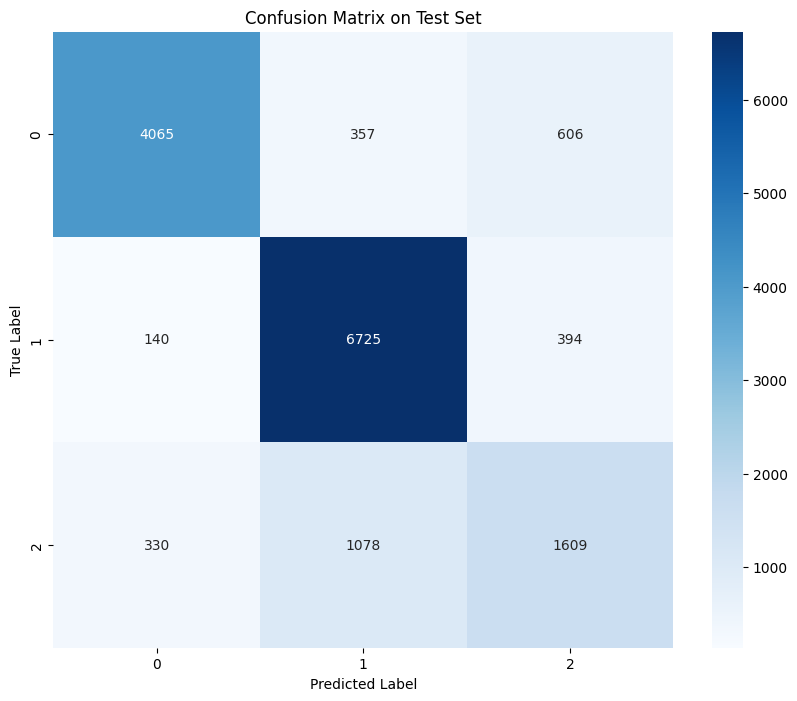


Classification Report:
              precision    recall  f1-score   support

     Dropout       0.90      0.81      0.85      5028
    Graduate       0.82      0.93      0.87      7259
    Enrolled       0.62      0.53      0.57      3017

    accuracy                           0.81     15304
   macro avg       0.78      0.76      0.76     15304
weighted avg       0.81      0.81      0.81     15304


Example Predictions:
True Label | Predicted | Probabilities (Dropout, Graduate, Enrolled)
-----------------------------------------------------------------
Graduate   | Graduate  | 0.009, 0.953, 0.038
Dropout    | Dropout   | 0.948, 0.002, 0.050
Enrolled   | Enrolled  | 0.215, 0.262, 0.523
Dropout    | Dropout   | 0.662, 0.212, 0.126
Enrolled   | Graduate  | 0.079, 0.545, 0.376
Dropout    | Dropout   | 0.999, 0.000, 0.001
Graduate   | Graduate  | 0.024, 0.870, 0.106
Enrolled   | Enrolled  | 0.286, 0.063, 0.652
Graduate   | Graduate  | 0.005, 0.972, 0.023
Enrolled   | Enrolled  | 0.156, 0

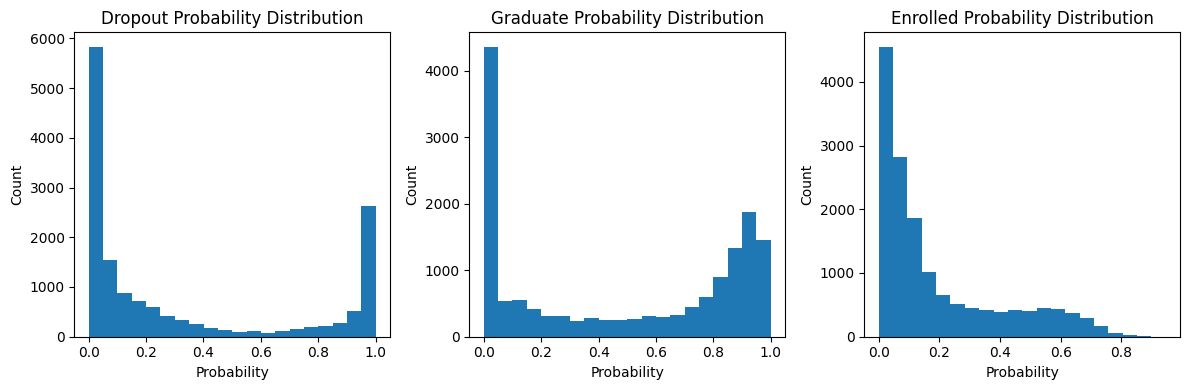

In [ ]:
# Preprocess test data - use same scaler as training data
X_test_np = X_test.values
X_test_scaled = scaler.transform(X_test_np)
X_test = torch.FloatTensor(X_test_scaled)
y_test = torch.LongTensor(y_test.values)

# Set model to evaluation mode
model.eval()

# Evaluate on test set
with torch.no_grad():
    # Get model predictions
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)

    # Calculate accuracy
    _, predicted = torch.max(test_outputs.data, 1)
    test_accuracy = (predicted == y_test).sum().item() / len(y_test)

    # Get probabilities
    probabilities = F.softmax(test_outputs, dim=1)

print('\nTest Set Results:')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {100*test_accuracy:.2f}%')

# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Calculate and plot confusion matrix
cm = confusion_matrix(y_test.numpy(), predicted.numpy())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print detailed classification report
target_names = ['Dropout', 'Graduate', 'Enrolled']
print('\nClassification Report:')
print(classification_report(y_test.numpy(), predicted.numpy(),
                          target_names=target_names))

# Show some example predictions
print('\nExample Predictions:')
print('True Label | Predicted | Probabilities (Dropout, Graduate, Enrolled)')
print('-' * 65)
for i in range(min(10, len(y_test))):  # Show first 10 examples
    true_label = target_names[y_test[i]]
    pred_label = target_names[predicted[i]]
    probs = probabilities[i].numpy()
    print(f'{true_label:10} | {pred_label:9} | {probs[0]:.3f}, {probs[1]:.3f}, {probs[2]:.3f}')

# Optional: Plot prediction probabilities distribution
plt.figure(figsize=(12, 4))
for i, label in enumerate(target_names):
    plt.subplot(1, 3, i+1)
    plt.hist(probabilities[:, i].numpy(), bins=20)
    plt.title(f'{label} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Gradient Boosting

Training Accuracy: 0.8306
              precision    recall  f1-score   support

           0       0.90      0.83      0.87     15160
           1       0.85      0.92      0.89     21775
           2       0.65      0.61      0.63      8975

    accuracy                           0.83     45910
   macro avg       0.80      0.79      0.79     45910
weighted avg       0.83      0.83      0.83     45910

Validation Accuracy: 0.3338
              precision    recall  f1-score   support

           0       0.33      1.00      0.50      5108
           1       0.00      0.00      0.00      7248
           2       0.00      0.00      0.00      2948

    accuracy                           0.33     15304
   macro avg       0.11      0.33      0.17     15304
weighted avg       0.11      0.33      0.17     15304

Test Accuracy: 0.3285
              precision    recall  f1-score   support

           0       0.33      1.00      0.49      5028
           1       0.00      0.00      0.00      7259

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

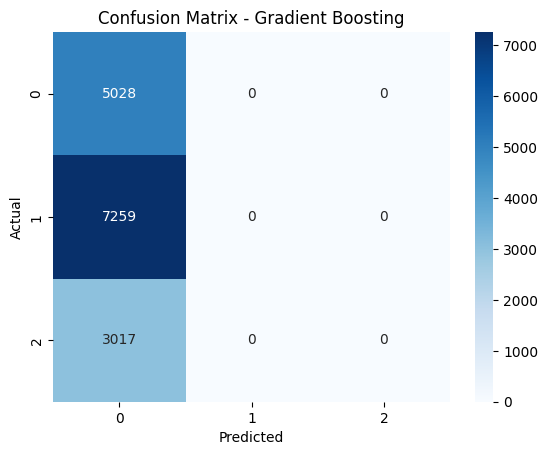

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_classifier.fit(X_train_scaled, y_train)


# Make predictions on the training set
y_train_pred = gb_classifier.predict(X_train_scaled)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(classification_report(y_train, y_train_pred))

# Scale the validation data
X_val_scaled = scaler.transform(X_val)

# Make predictions on the validation set
y_val_pred = gb_classifier.predict(X_val_scaled)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(classification_report(y_val, y_val_pred))

# Scale the test data
X_test_scaled = scaler.transform(X_test)
y_test_pred = gb_classifier.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

# Random Forest

Training Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15160
           1       1.00      1.00      1.00     21775
           2       1.00      1.00      1.00      8975

    accuracy                           1.00     45910
   macro avg       1.00      1.00      1.00     45910
weighted avg       1.00      1.00      1.00     45910

Validation Accuracy: 0.3338
              precision    recall  f1-score   support

           0       0.33      1.00      0.50      5108
           1       0.00      0.00      0.00      7248
           2       0.00      0.00      0.00      2948

    accuracy                           0.33     15304
   macro avg       0.11      0.33      0.17     15304
weighted avg       0.11      0.33      0.17     15304

Test Accuracy: 0.3285
              precision    recall  f1-score   support

           0       0.33      1.00      0.49      5028
           1       0.00      0.00      0.00      7259

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

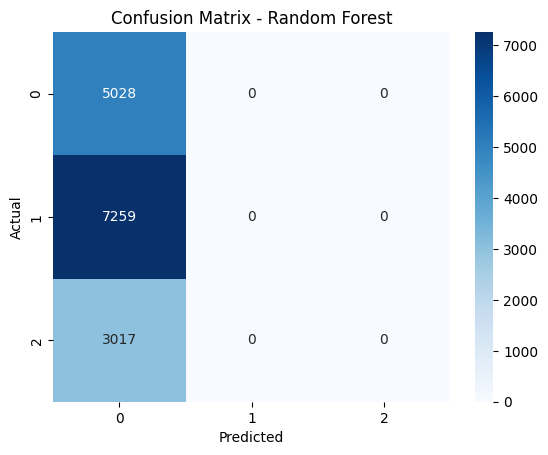

In [ ]:
# prompt: Generate a random forest classifier for the data above

from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions on the training set
y_train_pred = rf_classifier.predict(X_train_scaled)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(classification_report(y_train, y_train_pred))

# Scale the validation data (already scaled above, but repeating for clarity)
# X_val_scaled = scaler.transform(X_val)

# Make predictions on the validation set
y_val_pred = rf_classifier.predict(X_val_scaled)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(classification_report(y_val, y_val_pred))

# Scale the test data (already scaled above, but repeating for clarity)
# X_test_scaled = scaler.transform(X_test)

# Make predictions on the test set
y_test_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Ensemble Learning

In [ ]:
# prompt: Generate 2 ensemble learning models for the three models above, one should be voting and the other stacking

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.base import BaseEstimator, ClassifierMixin  # Import necessary classes

# Assuming 'model', 'gb_classifier', and 'rf_classifier' are already trained
# Wrap your PyTorch model in a scikit-learn compatible estimator using a custom class
class PyTorchClassifierWrapper(BaseEstimator, ClassifierMixin):  # Inherit from BaseEstimator and ClassifierMixin
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self  # No fitting needed as PyTorch model is already trained

    def predict(self, X):
        X_tensor = torch.FloatTensor(X)  # Convert to tensor
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs.data, 1)
        return predicted.numpy()  # Return numpy array for compatibility

    def score(self, X, y): # Implement score method
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

# Create a wrapped version of your PyTorch model
wrapped_model = PyTorchClassifierWrapper(model)
estimators = [('logistic', wrapped_model), ('gb', gb_classifier), ('rf', rf_classifier)]

# Voting Classifier
voting_clf = VotingClassifier(estimators=estimators, voting='hard') #'hard' for predicted class labels
voting_clf.fit(X_train_scaled, y_train)

# Evaluate Voting Classifier
y_pred_voting = voting_clf.predict(X_test_scaled)
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_voting))
print(classification_report(y_test, y_pred_voting))

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()) # Use logistic regression as the meta-learner
stacking_clf.fit(X_train_scaled, y_train)

# Evaluate Stacking Classifier
y_pred_stacking = stacking_clf.predict(X_test_scaled)
print("\nStacking Classifier Accuracy:", accuracy_score(y_test, y_pred_stacking))
print(classification_report(y_test, y_pred_stacking))

Voting Classifier Accuracy: 0.3285415577626764
              precision    recall  f1-score   support

           0       0.33      1.00      0.49      5028
           1       0.00      0.00      0.00      7259
           2       0.00      0.00      0.00      3017

    accuracy                           0.33     15304
   macro avg       0.11      0.33      0.16     15304
weighted avg       0.11      0.33      0.16     15304



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Stacking Classifier Accuracy: 0.3285415577626764
              precision    recall  f1-score   support

           0       0.33      1.00      0.49      5028
           1       0.00      0.00      0.00      7259
           2       0.00      0.00      0.00      3017

    accuracy                           0.33     15304
   macro avg       0.11      0.33      0.16     15304
weighted avg       0.11      0.33      0.16     15304



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
